### 1 - Importing packages

In [68]:
#Pacotes Básicos Python
import os
import string
import itertools
from collections import defaultdict

#Banco de Dados sqlite3
import sqlite3

#Pacotes de Suporte - pandas e numpy
import pandas as pd
import numpy as np

#Machine Learning
from scipy.sparse import csr_matrix,coo_matrix,hstack
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn import metrics
from sklearn import preprocessing #standarization, or mean removal and variance scaling
#Machine Learning - estimators
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

#Visualização de dados
import matplotlib.pyplot as plt

#Enchant - Correção Ortográfica
import enchant
from enchant import DictWithPWL
from enchant.checker import SpellChecker

#Persistência de Modelo
from sklearn.externals import joblib

### 2 - Pré-Processamento

In [2]:
#DROP
db = sqlite3.connect('projeto.db')
querySQL = db.execute("DROP TABLE PESQUISA")
db.commit()
db.close()

In [3]:
#CREATE TABLE
#Comando para criar a tabela no banco de dados. Só precisa ser executada uma única vez

db = sqlite3.connect('projeto.db')
db.execute('''CREATE TABLE PESQUISA
       (ID INT PRIMARY KEY    NOT NULL,
       COMENTARIO      TEXT,
       NOTA1           FLOAT,
       NOTA2           FLOAT,
       MANIFESTACAO    CHAR(20),
       MANIFATEN       CHAR(20),
       MANIFSERV       CHAR(20));''')
db.close()

In [4]:
#MaxID
db = sqlite3.connect('projeto.db')
cursor = db.execute('SELECT max(ID) FROM PESQUISA')
MaxID = cursor.fetchone()[0]

try:
    val = int(MaxID)
except:
    MaxID=0
    
print(MaxID)
db.close()

0


In [5]:
#Função para identificar o idioma da pesquisa de satisfação, baseada no idioma da Questão1
#Input : dataframe e Questão1 
#Output: inteiro com a codificação do idioma. 1-Portugês, 2-Espanhol, 3-Inglês ou outros
def setidioma (DF,Q):
    if Q == "Qual o seu nível de satisfação com esse atendimento?":
        return 1
    elif Q == "¿Cuál es su grado de satisfacción con este servicio?":
        return 2
    else:
        return 3

In [9]:
#Função para normalizar o campo 'Manifestação ao Atendimento' em: elogio, neutro e reclamação.
#Input : dataframe e campos de MANIFESTAÇÃO AO ATENDIMENTO e MANIFESTAÇÃO AO SERVIÇO 
#Output: MANIFESTAÇÃO normalizada
def setmanifestacao (DF,ATEN,SERV):
    positivo=["elogio","agradecimento"]
    neutro  =["neutro","sugestão"]
    negativo=["reclamação","insatisfeito","não-resolvido"]
    valido=positivo+neutro+negativo

    if   (str.lower(ATEN) in negativo) or (str.lower(SERV) in negativo):
        return "reclamação"
    elif (str.lower(ATEN) in positivo) or (str.lower(SERV) in positivo):
        return "elogio"
    elif (str.lower(ATEN) in neutro) and (str.lower(SERV) in neutro):
        return "neutro"
    elif (str.lower(ATEN) not in valido) or (str.lower(SERV) not in valido):
        return "invalido"
    else:
        return "erro"

In [10]:
#Função para INSERT na tabela PESQUISA do banco de dados
#Input : Ponteiro first_row_ID, indicando onde deve ser feito o INSERT na tabela PESQUISA e dicionário a ser inserido
#Output: Ponteiro com a nova posição após o último INSERT

def Insertdata(first_row_ID,dict1):
    db = sqlite3.connect('projeto.db')
    cursor = db.cursor()
    i=first_row_ID+1
    for com,cat,n1,n2,aten,serv in map(lambda *a: a,*zip(*itertools.zip_longest(dict1.get('Comentário'),dict1.get('Manifestação Ajustada'),dict1.get('Nota Questão 1'),dict1.get('Nota Questão 2'),dict1.get('Manifestação ao Atendimento'),dict1.get('Manifestação ao Serviço')))):
        cursor.execute("INSERT INTO PESQUISA (ID,COMENTARIO,NOTA1,NOTA2,MANIFESTACAO,MANIFATEN,MANIFSERV) VALUES (?,?,?,?,?,?,?)",(i, com, n1, n2, cat,aten,serv))
        i=i+1
    db.commit()

    #LAST ROW ID
    last_row_ID = cursor.lastrowid

    db.close()
    
    return(last_row_ID)

In [11]:
#Função para leitura do arquivo .csv
#Input : arquivo .csv 
#Output: Dicionário (dict)

def Createdict(csvfile):
    #Especificando os paths relativos para a leitura do arquivo .csv
    datapath = './datasets/'
    outputs = './outputs/'
    datafile = os.path.join(datapath, csvfile)
    
    #Armazenando todos os campos do arquivo .csv em um Pandas Dataframe
    df = pd.read_csv(datafile,dtype={'Nota Questão 1':float,'Nota Questão 2':float,'Número do Incidente':object,'Status':object,'Organização de Suporte':object,'Data da Resposta':object,'Grupo Designado':object,'Nível 1':object,'Nível 2':object,'Nível 3':object,'Questão 1':object,'Questão 2':object,'Questão 3':object,'Organização':object,'Localização no Trabalho':object,'Departamento':object,'Comentário':object,'P1 (Satisfação)':object,'P2 (Resolução)':object,'Manifestação ao Atendimento':object,'Manifestação ao Serviço':object,'Ações':object,'Novo Registro (caso Reabertura)':object,'Data corrigida':object})

    #Insere o valor "0" nas células que possuem Na/NaN das colunas selecionadas
    df['Comentário']=df.fillna(value="0")['Comentário']
    df['Manifestação ao Atendimento']=df.fillna(value="0")['Manifestação ao Atendimento']
    df['Manifestação ao Serviço']=df.fillna(value="0")['Manifestação ao Serviço']
    df['Ações']=df.fillna(value="0")['Ações']

    #Criando uma nova coluna "Idioma", com o objetivo de segregar as pesquisas de satisfação por idioma.
    df["Idioma"]=df.apply(lambda row: setidioma(df,row["Questão 1"]), axis=1)

    #Criando um Dataframe apenas com as perguntas em portugês - df_pt
    df_pt=df.copy()
    df_pt=df_pt[df_pt.Idioma == 1]

    #Removendo pesquisas que não possuem nenhum comentário, ou nenhuma manifestação preenchida manualmente
    df_pt = df_pt[df_pt['Comentário'] != '0']
    df_pt = df_pt[df_pt['Manifestação ao Atendimento'] != '0']
    df_pt = df_pt[df_pt['Manifestação ao Serviço'] != '0']
    
    #Normalizando o campo MANIFESTÇÃO AO ATENDIMENTO, através da criação do campo MANIFESTAÇÃO AJUSTADA
    df_pt["Manifestação Ajustada"]=df_pt.apply(lambda row: setmanifestacao(df_pt,row["Manifestação ao Atendimento"],row["Manifestação ao Serviço"]), axis=1)
    
    #Criando um Dicionário a partir do pandas Dataframe
    dict1 = {}
    dict1['Nota Questão 1']=df_pt['Nota Questão 1']
    dict1['Nota Questão 2']=df_pt['Nota Questão 2']
    dict1['Comentário']= df_pt['Comentário']
    dict1['Manifestação ao Atendimento']=df_pt['Manifestação ao Atendimento']
    dict1['Manifestação ao Serviço']=df_pt['Manifestação ao Serviço']
    dict1['Manifestação Ajustada']=df_pt['Manifestação Ajustada']
    return(dict1)

In [12]:
#Populando o banco de dados

#oversample2015-JANaJUL.csv'
#lista_csv=['2016.05.csv']
lista_csv=['2016.01.csv','2016.02.csv','2016.03.csv','2016.04.csv','2016.05.csv','2016.06.csv','2015.12.csv','2015.11.csv','2015.10.csv','2015.09.csv','2015.08.csv','2015.07.csv','2015.06.csv','2015.05.csv','2015.04.csv','2015.03.csv','2015.02.csv','2015.01.csv']
           
for doc in lista_csv:
    dict2=Createdict(doc)
    MaxID=Insertdata(MaxID,dict2)
    print(MaxID)

4963
9787
15662
20768
25580
30583
35431
39800
45497
51417
57512
63833
69771
75435
81534
88491
93364
99825


In [13]:
#Recuperando dados do banco de dados através do comando SELECT e armazenando em um Dictionary

dict3=defaultdict(list)

db = sqlite3.connect('projeto.db')
db.row_factory = sqlite3.Row
cursor =db.cursor()

querySQL = cursor.execute("SELECT ID,COMENTARIO,NOTA1,NOTA2,MANIFESTACAO,MANIFATEN,MANIFSERV from PESQUISA")

for row in querySQL:
    dict3['ID'].append(row[0])
    dict3['Comentário'].append(row[1])
    dict3['Nota Questão 1'].append(row[2])
    dict3['Nota Questão 2'].append(row[3])
    dict3['Manifestação Ajustada'].append(row[4])
    dict3['Manifestação ao Atendimento'].append(row[5])
    dict3['Manifestação ao Serviço'].append(row[6])
    
db.close()

In [14]:
#Processamento - STRIP-remove caracteres, LOWER-transforma caracteres em minúsculo e SPLIT-Separa as palavras no "Comentário"
words3 = [(i.strip('.,').lower().split(),category,n1,n2,m1,m2)
for i,category,n1,n2,m1,m2 in map(lambda *a: a,*zip(*itertools.zip_longest(dict3.get('Comentário'),dict3.get('Manifestação Ajustada'),dict3.get('Nota Questão 1'),dict3.get('Nota Questão 2'),dict3.get('Manifestação ao Atendimento'),dict3.get('Manifestação ao Serviço'))))]


In [15]:
#Transformando DE: Dictionary --> PARA: pandas Dataframe
rows=[]

for item in words3:
    rows.append({'text':" ".join(item[0]),'label':item[1],'nota1':item[2],'nota2':item[3],'Manif-ATEN':item[4],'Manif-SERV':item[5]})
df_scikit=pd.DataFrame(rows)

In [16]:
print("Total:       ",len(df_scikit.index))
print(df_scikit['label'].value_counts())

Total:        99825
elogio        65404
neutro        18756
reclamação    15665
Name: label, dtype: int64


In [17]:
print(len(df_scikit.index))
print(df_scikit.head())

99825
  Manif-ATEN Manif-SERV   label  nota1  nota2  \
0     Elogio     Neutro  elogio    5.0    5.0   
1     Elogio     Neutro  elogio    5.0    5.0   
2     Elogio     Neutro  elogio    5.0    5.0   
3     Neutro     Neutro  neutro    4.0    5.0   
4     Neutro     Neutro  neutro    2.0    1.0   

                                                text  
0  o atendimento foi ótimo. o funcionário merece ...  
1                       muito bom o serviço prestado  
2                            muito bom o atendimento  
3  devido estarmos em área remota. demorou mais d...  
4  o chamado foi resolvido momentaneamente apenas...  


In [18]:
#Tratando pesquisas de satisfação com campos não preenchidos. alterar para nota=3 ou nota=1 no caso de nao respondido
df_scikit['nota1']=(df_scikit.fillna(value=3)['nota1'].astype(np.float))
df_scikit['nota2']=(df_scikit.fillna(value=1)['nota2'].astype(np.float))

#### 2.1 - Enchant


In [19]:
d = DictWithPWL("pt_BR", "enchant-personal_word_list.txt")
chkr = SpellChecker(d)

In [20]:
lines = [line.rstrip('\n') for line in open('enchant-correction_word_list.txt')]

In [21]:
dict_enchant = dict((k.strip(), v.strip()) for k,v in 
              (item.split(';') for item in lines))

In [22]:
def enchant_correct(DF,survey):
    chkr.set_text(survey)
    for err in chkr:
        if err.word in dict_enchant.keys():
            survey=survey.replace(err.word, dict_enchant[err.word])
    return(survey)

In [23]:
#corrige o dataframe fazendo as correções necessárias como acentuação, palavras erradas, etc
df_scikit["text"]=df_scikit.apply(lambda row: enchant_correct(df_scikit,row["text"]), axis=1)

In [24]:
df_scikit['text'][0:5]

0    o atendimento foi ótimo. o funcionário merece ...
1                         muito bom o serviço prestado
2                              muito bom o atendimento
3    devido estarmos em área remota. demorou mais d...
4    o chamado foi resolvido momentaneamente apenas...
Name: text, dtype: object

In [25]:
"""
chkr.set_text("atendimeto tic foi dip SAP otimo. o funcinoário merece umm elogio")
for err in chkr:
    print ("ERROR:", err.word," - Sugestão:", d.suggest(err.word)[0])
    
lista_erro=[]
for survey in df_scikit['text']:
    chkr.set_text(survey)
    for err in chkr:
        lista_erro.append(err.word)

print(len(lista_erro))
print(len(set(lista_erro)))
from collections import Counter
for item in Counter(lista_erro).most_common(200):
    print (item,d.suggest(item[0]))
"""


'\nchkr.set_text("atendimeto tic foi dip SAP otimo. o funcinoário merece umm elogio")\nfor err in chkr:\n    print ("ERROR:", err.word," - Sugestão:", d.suggest(err.word)[0])\n    \nlista_erro=[]\nfor survey in df_scikit[\'text\']:\n    chkr.set_text(survey)\n    for err in chkr:\n        lista_erro.append(err.word)\n\nprint(len(lista_erro))\nprint(len(set(lista_erro)))\nfrom collections import Counter\nfor item in Counter(lista_erro).most_common(200):\n    print (item,d.suggest(item[0]))\n'

#### 2.2 - Matplotlib - Summary


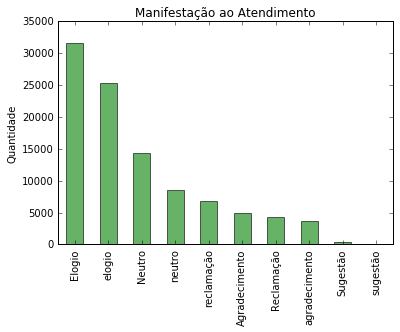

In [26]:
%matplotlib inline
plt.ylabel('Quantidade')
plt.title('Manifestação ao Atendimento')
(df_scikit['Manif-ATEN'].value_counts()).plot(kind='bar',color='g',alpha=0.6,figsize=(6, 4))

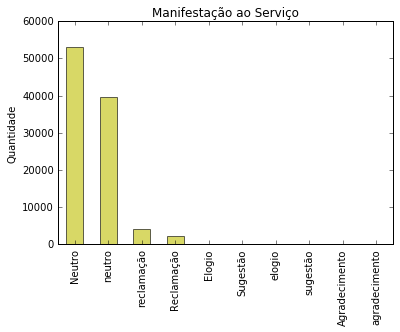

In [27]:
plt.ylabel('Quantidade')
plt.title('Manifestação ao Serviço')
(df_scikit['Manif-SERV'].value_counts()).plot(kind='bar',color='y',alpha=0.6,figsize=(6, 4))

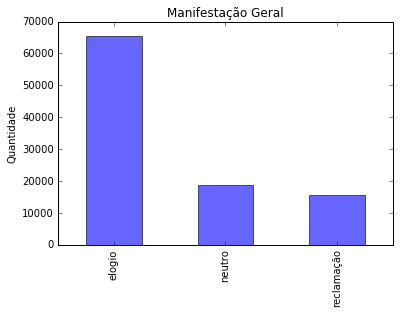

In [28]:
plt.ylabel('Quantidade')
plt.title('Manifestação Geral')
(df_scikit['label'].value_counts()).plot(kind='bar',alpha=0.6,figsize=(6, 4))

#### 2.3 - Standardization, or mean removal and variance scaling

In [45]:
print(df_scikit['nota1'].value_counts())
print(df_scikit['nota2'].value_counts())

5.0    76621
1.0     8847
4.0     6468
3.0     5215
2.0     2674
Name: nota1, dtype: int64
5.0    81058
1.0    18767
Name: nota2, dtype: int64


In [52]:
n1=(df_scikit['nota1'].values)
n2=(df_scikit['nota2'].values)

n1_scaled=n1.reshape(-1,1)
n2_scaled=n2.reshape(-1,1)

In [35]:
"""
min_max_scaler = preprocessing.MinMaxScaler()
n1_scaled = min_max_scaler.fit_transform(n1.reshape(-1,1))
n2_scaled = min_max_scaler.fit_transform(n2.reshape(-1,1))
"""

"\nn1=(df_scikit['nota1'].values)\nn2=(df_scikit['nota2'].values)\nmin_max_scaler = preprocessing.MinMaxScaler()\nn1_scaled = min_max_scaler.fit_transform(n1.reshape(-1,1))\nn2_scaled = min_max_scaler.fit_transform(n2.reshape(-1,1))\n"

In [53]:
unique, counts = np.unique(n1_scaled, return_counts=True)
print (np.asarray((unique, counts)).T)
unique, counts = np.unique(n2_scaled, return_counts=True)
print (np.asarray((unique, counts)).T)
print(n1_scaled.shape,"   -    ",n2_scaled.shape)

[[  1.00000000e+00   8.84700000e+03]
 [  2.00000000e+00   2.67400000e+03]
 [  3.00000000e+00   5.21500000e+03]
 [  4.00000000e+00   6.46800000e+03]
 [  5.00000000e+00   7.66210000e+04]]
[[  1.00000000e+00   1.87670000e+04]
 [  5.00000000e+00   8.10580000e+04]]
(99825, 1)    -     (99825, 1)


### 3 - Processamento - Scikit Learn

### 3.1 - Models - Cross Validation & Stratified KFold

In [54]:
#bag of words features
count_vect = CountVectorizer()
count_vect.fit(df_scikit['text'].values)
data = count_vect.transform(df_scikit['text'].values)

#term frequency features
tf_transformer = TfidfTransformer(use_idf=False).fit(data)
data_features_tf = tf_transformer.transform(data)

In [55]:
from sklearn import cross_validation
train_comments, test_comments, train_labels, test_labels = cross_validation.train_test_split(data_features_tf, df_scikit['label'].values, test_size=0.2, random_state=0)

#### Incluindo informações adicionais de Nota1 e Nota2 como features do modelo

In [56]:
#n1=coo_matrix(df_scikit['nota1'].values)
#n2=coo_matrix(df_scikit['nota2'].values)
#n1=coo_matrix(n1)
#n2=coo_matrix(n2)
print(data_features_tf.shape)

data_features_tf2=csr_matrix(hstack([coo_matrix(data_features_tf),coo_matrix(n1_scaled)]))
data_features_tf2=csr_matrix(hstack([coo_matrix(data_features_tf2),coo_matrix(n2_scaled)]))

print(n1_scaled.shape)
print(n2_scaled.shape)
print(data_features_tf2.shape)

(99825, 27385)
(99825, 1)
(99825, 1)
(99825, 27387)


In [57]:
from sklearn import cross_validation
train_comments2, test_comments2, train_labels2, test_labels2 = cross_validation.train_test_split(data_features_tf2, df_scikit['label'].values, test_size=0.2, random_state=0)

#### 3.1.1 - Model 1 - SVM (kernel=linear)


In [58]:
clf = svm.SVC(kernel='linear', C=1,cache_size=1000).fit(train_comments, train_labels)
clf.score(test_comments, test_labels)

0.85018782870022536

In [59]:
clf2 = svm.SVC(kernel='linear', C=1,cache_size=1000).fit(train_comments2, train_labels2)
clf2.score(test_comments2, test_labels2)

0.86641622839969945

When the cv argument is an integer, cross_val_score uses the KFold or StratifiedKFold strategies by default, the latter being used if the estimator derives from ClassifierMixin.

In [201]:
n_samples=data_features_tf.shape[0]
cv = cross_validation.ShuffleSplit(n_samples, n_iter=5, test_size=0.2, random_state=23)
scores_SVM = cross_validation.cross_val_score(clf, data_features_tf, df_scikit['label'].values , cv=cv)

In [202]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_SVM.mean(), scores_SVM.std() * 2))
print(scores_SVM)

Accuracy: 0.88 (+/- 0.03)
[ 0.85981308  0.90031153  0.87227414  0.88265836  0.87435099]


In [60]:
docs_new=['nada a declarar','Ok','rápido e atencioso','fecharam o chamado sem me avisar. absurdo','como sempre, muito lento','não fizeram mais do que o esperado. nem satisfeito nem insatisfeito', 'depois de 5 dias me retornaram dizendo que não podiam fazer nada pelo problema!!!!']
nota1_new=coo_matrix([5.0,3.0,5.0,2.0,2.0,4.0,1.0])
nota2_new=coo_matrix([5.0,5.0,5.0,1.0,5.0,5.0,1.0])
#-------------------------------------------------------------------
counts_new = count_vect.transform(docs_new)
counts_new_tf = tf_transformer.transform(counts_new)

counts_new_tf=csr_matrix(hstack([coo_matrix(counts_new_tf),nota1_new.transpose()]))
counts_new_tf=csr_matrix(hstack([coo_matrix(counts_new_tf),nota2_new.transpose()]))

predicted = clf2.predict(counts_new_tf)

for doc,category in zip(docs_new,predicted):
    print(doc,category)

nada a declarar neutro
Ok neutro
rápido e atencioso elogio
fecharam o chamado sem me avisar. absurdo reclamação
como sempre, muito lento reclamação
não fizeram mais do que o esperado. nem satisfeito nem insatisfeito neutro
depois de 5 dias me retornaram dizendo que não podiam fazer nada pelo problema!!!! reclamação


#### 3.1.2 - Model 2 - SVM (kernel=Gaussian RBF)


In [61]:
clf3 = svm.SVC(kernel='rbf', C=1,cache_size=1000).fit(train_comments, train_labels)
clf3.score(test_comments, test_labels)

0.65314300025043825

In [62]:
clf4 = svm.SVC(kernel='rbf', C=1,cache_size=1000).fit(train_comments2, train_labels2)
clf4.score(test_comments2, test_labels2)

0.77721011770598547

When the cv argument is an integer, cross_val_score uses the KFold or StratifiedKFold strategies by default, the latter being used if the estimator derives from ClassifierMixin.

In [64]:
docs_new=['nada a declarar','Ok','rápido e atencioso','fecharam o chamado sem me avisar. absurdo','como sempre, muito lento','não fizeram mais do que o esperado. nem satisfeito nem insatisfeito', 'depois de 5 dias me retornaram dizendo que não podiam fazer nada pelo problema!!!!']
nota1_new=coo_matrix([5.0,3.0,5.0,2.0,2.0,4.0,1.0])
nota2_new=coo_matrix([5.0,5.0,5.0,1.0,5.0,5.0,1.0])
#-------------------------------------------------------------------
counts_new = count_vect.transform(docs_new)
counts_new_tf = tf_transformer.transform(counts_new)

counts_new_tf=csr_matrix(hstack([coo_matrix(counts_new_tf),nota1_new.transpose()]))
counts_new_tf=csr_matrix(hstack([coo_matrix(counts_new_tf),nota2_new.transpose()]))

predicted = clf4.predict(counts_new_tf)

for doc,category in zip(docs_new,predicted):
    print(doc,category)

nada a declarar elogio
Ok elogio
rápido e atencioso elogio
fecharam o chamado sem me avisar. absurdo reclamação
como sempre, muito lento reclamação
não fizeram mais do que o esperado. nem satisfeito nem insatisfeito elogio
depois de 5 dias me retornaram dizendo que não podiam fazer nada pelo problema!!!! reclamação


#### 3.1.3 - Model 3 - Naive Bayes (Multinomial Naive Bayes)


In [65]:
clf5 = MultinomialNB().fit(train_comments, train_labels)
clf5.score(test_comments, test_labels)

0.81272226396193337

In [66]:
clf6 = MultinomialNB().fit(train_comments2, train_labels2)
clf6.score(test_comments2, test_labels2)

0.81001753067868776

When the cv argument is an integer, cross_val_score uses the KFold or StratifiedKFold strategies by default, the latter being used if the estimator derives from ClassifierMixin.

In [67]:
docs_new=['nada a declarar','Ok','rápido e atencioso','fecharam o chamado sem me avisar. absurdo','como sempre, muito lento','não fizeram mais do que o esperado. nem satisfeito nem insatisfeito', 'depois de 5 dias me retornaram dizendo que não podiam fazer nada pelo problema!!!!']
nota1_new=coo_matrix([5.0,3.0,5.0,2.0,2.0,4.0,1.0])
nota2_new=coo_matrix([5.0,5.0,5.0,1.0,5.0,5.0,1.0])
#-------------------------------------------------------------------
counts_new = count_vect.transform(docs_new)
counts_new_tf = tf_transformer.transform(counts_new)

counts_new_tf=csr_matrix(hstack([coo_matrix(counts_new_tf),nota1_new.transpose()]))
counts_new_tf=csr_matrix(hstack([coo_matrix(counts_new_tf),nota2_new.transpose()]))

predicted = clf6.predict(counts_new_tf)

for doc,category in zip(docs_new,predicted):
    print(doc,category)

nada a declarar neutro
Ok elogio
rápido e atencioso elogio
fecharam o chamado sem me avisar. absurdo reclamação
como sempre, muito lento elogio
não fizeram mais do que o esperado. nem satisfeito nem insatisfeito neutro
depois de 5 dias me retornaram dizendo que não podiam fazer nada pelo problema!!!! reclamação


#### 3.1.4 - Model 4 - SGD (Stochastic Gradient Descent)


In [97]:
clf7 = SGDClassifier(loss="hinge", penalty="l2",n_iter=50)
print(clf7)
clf7.fit(train_comments, train_labels)
clf7.score(test_comments, test_labels)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)


0.84102178812922612

In [98]:
clf8 = SGDClassifier(loss="hinge", penalty="l2",n_iter=50)
print(clf8)
clf8.fit(train_comments2, train_labels2)
clf8.score(test_comments2, test_labels2)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)


0.8613072877535688

When the cv argument is an integer, cross_val_score uses the KFold or StratifiedKFold strategies by default, the latter being used if the estimator derives from ClassifierMixin.

In [77]:
docs_new=['nada a declarar','Ok','rápido e atencioso','fecharam o chamado sem me avisar. absurdo','como sempre, muito lento','não fizeram mais do que o esperado. nem satisfeito nem insatisfeito', 'depois de 5 dias me retornaram dizendo que não podiam fazer nada pelo problema!!!!']
nota1_new=coo_matrix([5.0,3.0,5.0,2.0,2.0,4.0,1.0])
nota2_new=coo_matrix([5.0,5.0,5.0,1.0,5.0,5.0,1.0])
#-------------------------------------------------------------------
counts_new = count_vect.transform(docs_new)
counts_new_tf = tf_transformer.transform(counts_new)

counts_new_tf=csr_matrix(hstack([coo_matrix(counts_new_tf),nota1_new.transpose()]))
counts_new_tf=csr_matrix(hstack([coo_matrix(counts_new_tf),nota2_new.transpose()]))

predicted = clf8.predict(counts_new_tf)

for doc,category in zip(docs_new,predicted):
    print(doc,category)

nada a declarar neutro
Ok neutro
rápido e atencioso elogio
fecharam o chamado sem me avisar. absurdo reclamação
como sempre, muito lento reclamação
não fizeram mais do que o esperado. nem satisfeito nem insatisfeito neutro
depois de 5 dias me retornaram dizendo que não podiam fazer nada pelo problema!!!! reclamação


#### 3.2 - Metrics


In [87]:
#clf = svm.SVC(kernel='linear', C=1)
#clf = clf.fit(train_comments,train_labels)
predicted = clf7.predict(test_comments)
print(np.mean(predicted == test_labels))

0.840420736289


In [88]:
print(metrics.classification_report(test_labels,predicted))

             precision    recall  f1-score   support

     elogio       0.93      0.97      0.95     13040
     neutro       0.66      0.50      0.57      3754
 reclamação       0.64      0.72      0.68      3171

avg / total       0.83      0.84      0.83     19965



In [89]:
print(metrics.confusion_matrix(test_labels,predicted))

[[12636   245   159]
 [  789  1866  1099]
 [  189   705  2277]]


#### 3.3 - Model Persistence
Após o treinamento de um modelo scikit-learn, é desejável criar formas de persistir o modelo para uso futuro, sem a necessidade de realizar o treinamento novamente.

In [83]:
def dump_model(estimator,filename):
    outputs = './outputs/'
    datafile = os.path.join(outputs,filename)
    
    joblib.dump(estimator, datafile)

In [84]:
def load_model(filename):
    outputs = './outputs/'
    datafile = os.path.join(outputs,filename)
    
    return(joblib.load(datafile))

In [99]:
dump_model(clf ,'model1a.pk1')
dump_model(clf2,'model1b.pk1')
dump_model(clf3,'model2a.pk1')
dump_model(clf4,'model2b.pk1')
dump_model(clf5,'model3a.pk1')
dump_model(clf6,'model3b.pk1')
dump_model(clf7,'model4a.pk1')
dump_model(clf8,'model4b.pk1')


dump_model(test_comments,'test_comments.data')
dump_model(test_labels,'test_labels.data')
dump_model(test_comments2,'test_comments2.data')
dump_model(test_labels2,'test_labels2.data')

In [100]:
clf  = load_model('model1a.pk1')
clf2 = load_model('model1b.pk1')
clf3 = load_model('model2a.pk1')
clf4 = load_model('model2b.pk1')
clf5 = load_model('model3a.pk1')
clf6 = load_model('model3b.pk1')
clf7 = load_model('model4a.pk1')
clf8 = load_model('model4b.pk1')

test_comments  = load_model('test_comments.data')
test_labels    = load_model('test_labels.data') 
test_comments2 = load_model('test_comments2.data')
test_labels2   = load_model('test_labels2.data') 

In [101]:
print(clf5.score(test_comments, test_labels))
print(clf6.score(test_comments2, test_labels2))
print(clf7.score(test_comments, test_labels))
print(clf8.score(test_comments2, test_labels2))

0.812722263962
0.810017530679
0.841021788129
0.861307287754


#### 3.4 - GridSearch


#### 3.X - T-sne / Outlier detection


TruncatedSVD

Dimensionality reduction using truncated SVD (aka LSA).

This transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). It is very similar to PCA, but operates on sample vectors directly, instead of on a covariance matrix. This means it can work with scipy.sparse matrices efficiently.

In [ ]:
print(type(data_features_tf))
print((data_features_tf.shape))
print(type(train_comments))
print((train_comments.shape))
print(type(train_labels))
print((train_labels.shape))

In [ ]:
from sklearn.decomposition import TruncatedSVD

In [ ]:
svd = TruncatedSVD(n_components=50, random_state=42)
svd.fit(train_comments)

In [ ]:
print(svd.explained_variance_ratio_)
print(svd.explained_variance_ratio_.sum())

In [ ]:
train_SVD=svd.transform(train_comments)

In [ ]:
print(train_SVD.shape)
print(train_SVD)

t-distributed Stochastic Neighbor Embedding.

t-SNE [1] is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

It is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high. This will suppress some noise and speed up the computation of pairwise distances between samples. For more tips see Laurens van der Maaten’s FAQ [2].

In [ ]:
from sklearn.manifold import TSNE

#### 3.X - Voting


In [125]:
from sklearn.ensemble import VotingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

clf1 = LogisticRegression(random_state=0)
clf2 = RandomForestClassifier(random_state=0)
clf3 = GaussianNB()

In [126]:
train_comments, test_comments, train_labels, test_labels = cross_validation.train_test_split(data_features_tf, df_scikit['label'].values, test_size=0.2, random_state=0)

In [127]:
eclf1 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')

In [128]:
eclf1.fit(train_comments, train_labels)

TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

In [ ]:
eclf1.score(test_comments, test_labels)

#### 3.X - Hot Test


In [ ]:
"""
predicted = clf.predict(data_features_tf[:,:])
df_scikit["predicted"]=predicted

writer = pd.ExcelWriter('output.xlsx')
df_scikit.to_excel(writer,'Sheet1')
writer.save()
"""

In [ ]:
#INSERT DATA IN TABLE PESQUISA
def Insertdata2(first_row_ID,dict1):
    db = sqlite3.connect('projeto.db')
    cursor = db.cursor()
    i=first_row_ID+1
    for com,cat,n1,n2 in map(lambda *a: a,*zip(*itertools.zip_longest(dict1.get('Comentário'),dict1.get('Manifestação ao Atendimento'),dict1.get('Nota Questão 1'),dict1.get('Nota Questão 2')))):
        cursor.execute("INSERT INTO TESTE (ID,COMENTARIO,NOTA1,NOTA2,MANIFESTACAO) VALUES (?,?,?,?,?)",(i, com, n1, n2, cat))
        i=i+1
    db.commit()

    #LAST ROW ID
    last_row_ID = cursor.lastrowid

    db.close()
    
    return(last_row_ID)

In [ ]:
#DROP
db = sqlite3.connect('projeto.db')
querySQL = db.execute("DROP TABLE TESTE")
db.commit()
db.close()

In [ ]:
#CREATE TABLE
#Comando para criar a tabela no banco de dados. Só precisa ser executada uma única vez

db = sqlite3.connect('projeto.db')
db.execute('''CREATE TABLE TESTE
       (ID INT PRIMARY KEY    NOT NULL,
       COMENTARIO      TEXT,
       NOTA1           FLOAT,
       NOTA2           FLOAT,
       MANIFESTACAO    CHAR(20));''')
db.close()

In [ ]:
#MaxID
db = sqlite3.connect('projeto.db')
cursor = db.execute('SELECT max(ID) FROM TESTE')
MaxID = cursor.fetchone()[0]

try:
    val = int(MaxID)
except:
    MaxID=0
    
print(MaxID)
db.close()

In [ ]:
lista_csv2=['2016.05.csv']
for doc in lista_csv2:
    dict2=Createdict(doc)
    MaxID=Insertdata2(MaxID,dict2)
    print(MaxID)

In [ ]:
#RETRIEVING DATA FROM THE DATABASE

dict3=defaultdict(list)

db = sqlite3.connect('projeto.db')
db.row_factory = sqlite3.Row
cursor =db.cursor()

querySQL = cursor.execute("SELECT ID,COMENTARIO,NOTA1,NOTA2,MANIFESTACAO from TESTE")

for row in querySQL:
    dict3['ID'].append(row[0])
    dict3['Comentário'].append(row[1])
    dict3['Nota Questão 1'].append(row[2])
    dict3['Nota Questão 2'].append(row[3])
    dict3['Manifestação ao Atendimento'].append(row[4])
    
db.close()

In [ ]:
words3 = [(i.strip('.,').lower().split(),category,n1,n2 )
for i,category,n1,n2 in map(lambda *a: a,*zip(*itertools.zip_longest(dict3.get('Comentário'),dict3.get('Manifestação ao Atendimento'),dict3.get('Nota Questão 1'),dict3.get('Nota Questão 2'))))]


In [ ]:
rows=[]

for item in words3:
    rows.append({'text':" ".join(item[0]),'label':item[1],'nota1':item[2],'nota2':item[3]})
df_minority=pd.DataFrame(rows)

In [ ]:
#alterar para jogar nota=3 no caso de nao respondido ao inves de nota=0
df_minority['nota1']=(df_minority.fillna(value=3)['nota1'].astype(np.float))
df_minority['nota2']=(df_minority.fillna(value=1)['nota2'].astype(np.float))

In [ ]:
#bag of words features

data = count_vect.transform(df_minority['text'].values)

#term frequency features
tf_transformer = TfidfTransformer(use_idf=False).fit(data)
data_features_tf = tf_transformer.transform(data)

In [ ]:
n1=coo_matrix(df_minority['nota1'].values)
n2=coo_matrix(df_minority['nota2'].values)
print(data_features_tf.shape)

data_features_tf=csr_matrix(hstack([coo_matrix(data_features_tf),n1.transpose()]))
data_features_tf=csr_matrix(hstack([coo_matrix(data_features_tf),n2.transpose()]))


print(n1.transpose().shape)
print(n2.transpose().shape)
print(data_features_tf.shape)

In [ ]:
predicted = clf.predict(data_features_tf[:,:])
print(np.mean(predicted == df_minority['label'][:].values))

In [ ]:
print(metrics.confusion_matrix(df_minority['label'][:].values,predicted))

In [ ]:
df_minority["predicted"]=predicted
df_minority = df_minority[['label','predicted', 'nota1', 'nota2', 'text']]
df_minority.columns=['Manifestação ao Atendimento','predicted', 'Nota Questão 1', 'Nota Questão 2', 'Comentário']
writer = pd.ExcelWriter('output.xlsx')
df_minority.to_excel(writer,'Sheet1')
writer.save()